In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [40]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
from statistics_methods.Statistics import StatisticsWrapper
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import shap
from statistics_methods.plots import PlotsManager
import numpy as np

In [3]:
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS

In [93]:
def load_data(data_path, outliers=[]):
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]
    chosen_data = chosen_data.drop(columns=constants.SLOPES)
    chosen_data['ROI'] = chosen_data['ROI'].astype(str)
    chosen_data['subjects'] = chosen_data['subjects'].astype(str)

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects

def show_correlations_stats(all_data, young_data, old_data, method, eval_data=None):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single',
                                                                title="all")['dendrogram_data']['ivl']
    young_result = StatisticsWrapper.roi_correlations(young_data, params_to_work_with, clusters_rois,
                                                        group_title='Correlations of young group', method=method)
    old_result = StatisticsWrapper.roi_correlations(old_data, params_to_work_with, clusters_rois,
                                                     group_title='Correlations of old group', method=method)
                        
    PlotsManager.plot_heatmap(old_result - young_result, 'differences of old and young', project_name=None)
    young_corr_means, old_corr_means  = show_corr_mean(young_result, old_result, clusters_rois, 'Average correlations', eval_data)

def show_corr_mean(young_result, old_result, clusters_rois, title, eval_data):
    young_result['corr_mean'] = young_result.apply(np.mean, axis=1)
    old_result['corr_mean'] = old_result.apply(np.mean, axis=1)
    eval_data_orederd = eval_data.copy()
    eval_data_orederd.index = eval_data_orederd['ROI']
    eval_data_orederd = eval_data_orederd.reindex(clusters_rois)

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(f'{title}')
    ax.scatter(clusters_rois, young_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='young')
    ax.scatter(clusters_rois, old_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='old')
    ax.scatter(clusters_rois, eval_data_orederd['Accuracy'], color='black', s=20, alpha=0.7, label='model accuracy', marker='^')
    ax.plot(clusters_rois, eval_data_orederd['Accuracy'], color='black')
    ax.plot(clusters_rois, young_result['corr_mean'].to_numpy(), color='blue')
    ax.plot(clusters_rois, old_result['corr_mean'].to_numpy(), color='red')

    ax.set_xticks(clusters_rois)
    ax.set_xticklabels(clusters_rois, rotation='vertical', fontsize=10)

    # Connecting the points with vertical lines
    for x, y1, y2 in zip(clusters_rois, young_result['corr_mean'].to_numpy(), old_result['corr_mean'].to_numpy()):
        plt.plot([x, x], [y1, y2], color='gray', linestyle='--')
        
    # ax.set_facecolor('white')
    ax.legend()
    ax.grid(True)

    return young_result['corr_mean'], old_result['corr_mean']

def create_evaluation_report(data, y_test, y_pred):
    # Add predictions to the test dataset
    test_results = data.copy()
    test_results["predicted_label"] = y_pred
    test_results["label"] = y_test

    # Group by name and calculate evaluation metrics for each group
    name_groups = test_results.groupby("ROI_name")
    evaluation_results = []

    for name, group in name_groups:
        true_labels = group["label"]
        predicted_labels = group["predicted_label"]
        
        evaluation_results.append({
            "ROI": name,
            "Accuracy": accuracy_score(true_labels, predicted_labels),
            "Precision": precision_score(true_labels, predicted_labels),
            "Recall": recall_score(true_labels, predicted_labels),
            "F1-score": f1_score(true_labels, predicted_labels)
        })

    # Convert evaluation results to DataFrame for easier visualization
    evaluation_df = pd.DataFrame(evaluation_results)
    return evaluation_df

In [42]:
outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB']
# outliers = []
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(constants.PATH_TO_CORTEX_all_params_raw, outliers=outliers)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(constants.PATH_TO_CORTEX_all_params_z_score, outliers=outliers)

# Cortex binary classification

In [43]:
data = chosen_data_raw.copy()
seed = 42
young_mask = young_subjects_raw.index
old_mask = old_subjects_raw.index

# Assign labels directly to data_reduced_tsne DataFrame
data.loc[young_mask, 'label'] = 0
data.loc[old_mask, 'label'] = 1

data = data.sample(frac=1)

x, y = data.drop(columns=['label']), data['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=data['ROI_name'], random_state=seed)

In [44]:
model = xgb.XGBClassifier(random_state=seed)
model.fit(x_train[params_to_work_with], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [45]:
#Making predictions on the test set
predictions = model.predict(x_test[params_to_work_with])

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['young', 'old']))

Accuracy: 0.8708708708708709

Classification Report:
              precision    recall  f1-score   support

       young       0.86      0.89      0.87       166
         old       0.88      0.86      0.87       167

    accuracy                           0.87       333
   macro avg       0.87      0.87      0.87       333
weighted avg       0.87      0.87      0.87       333



/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:534: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


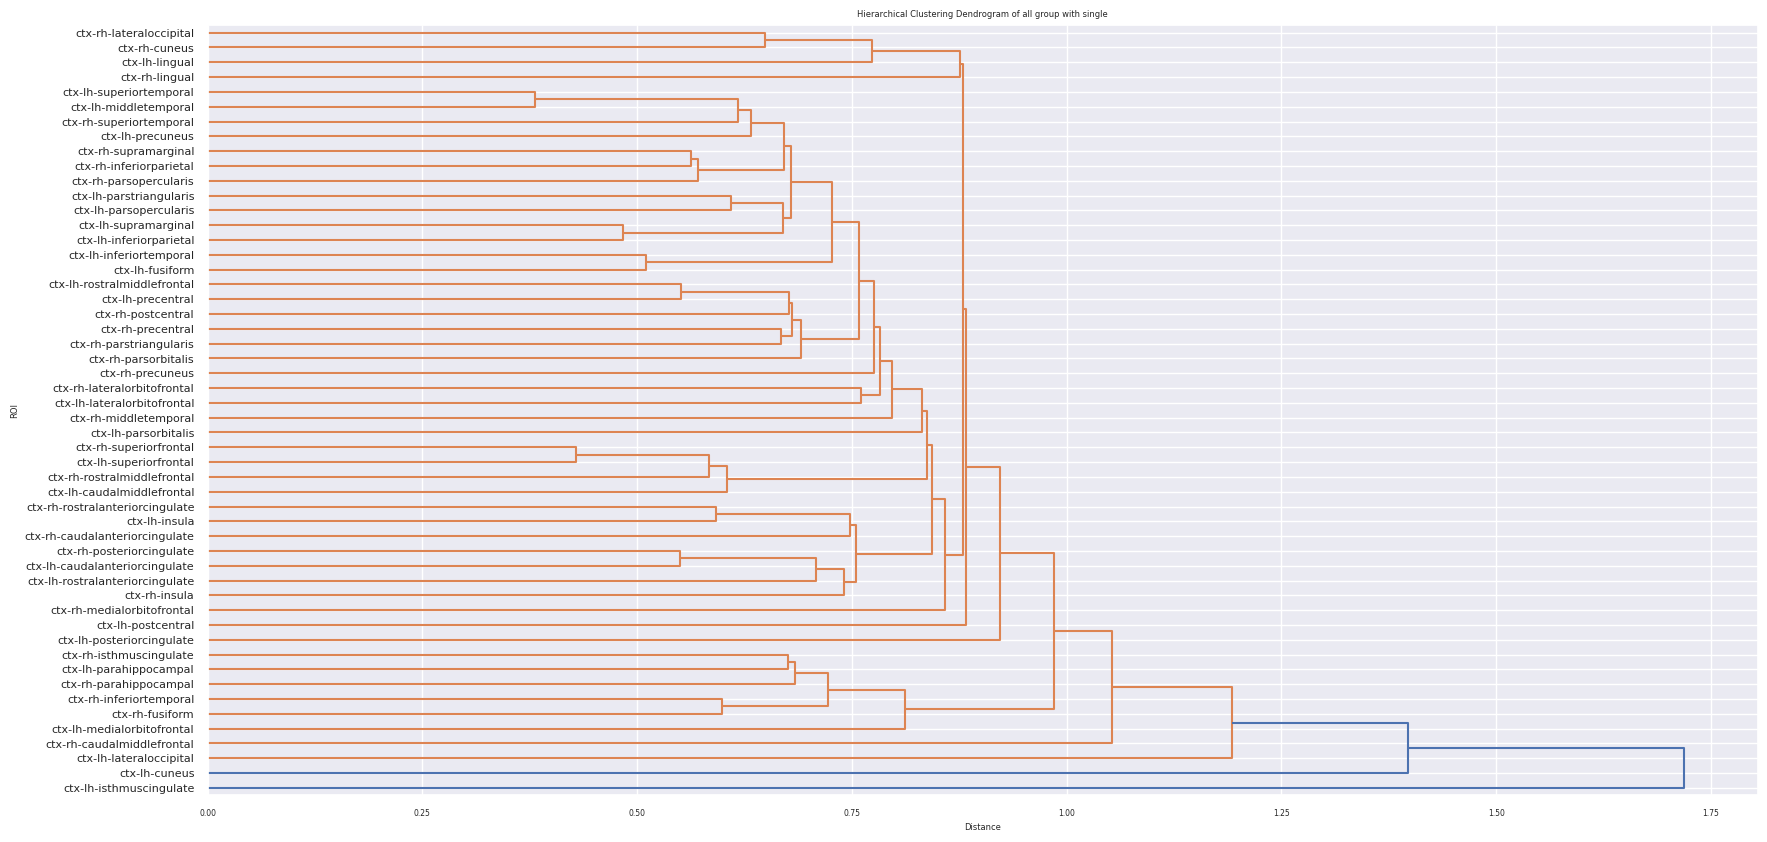

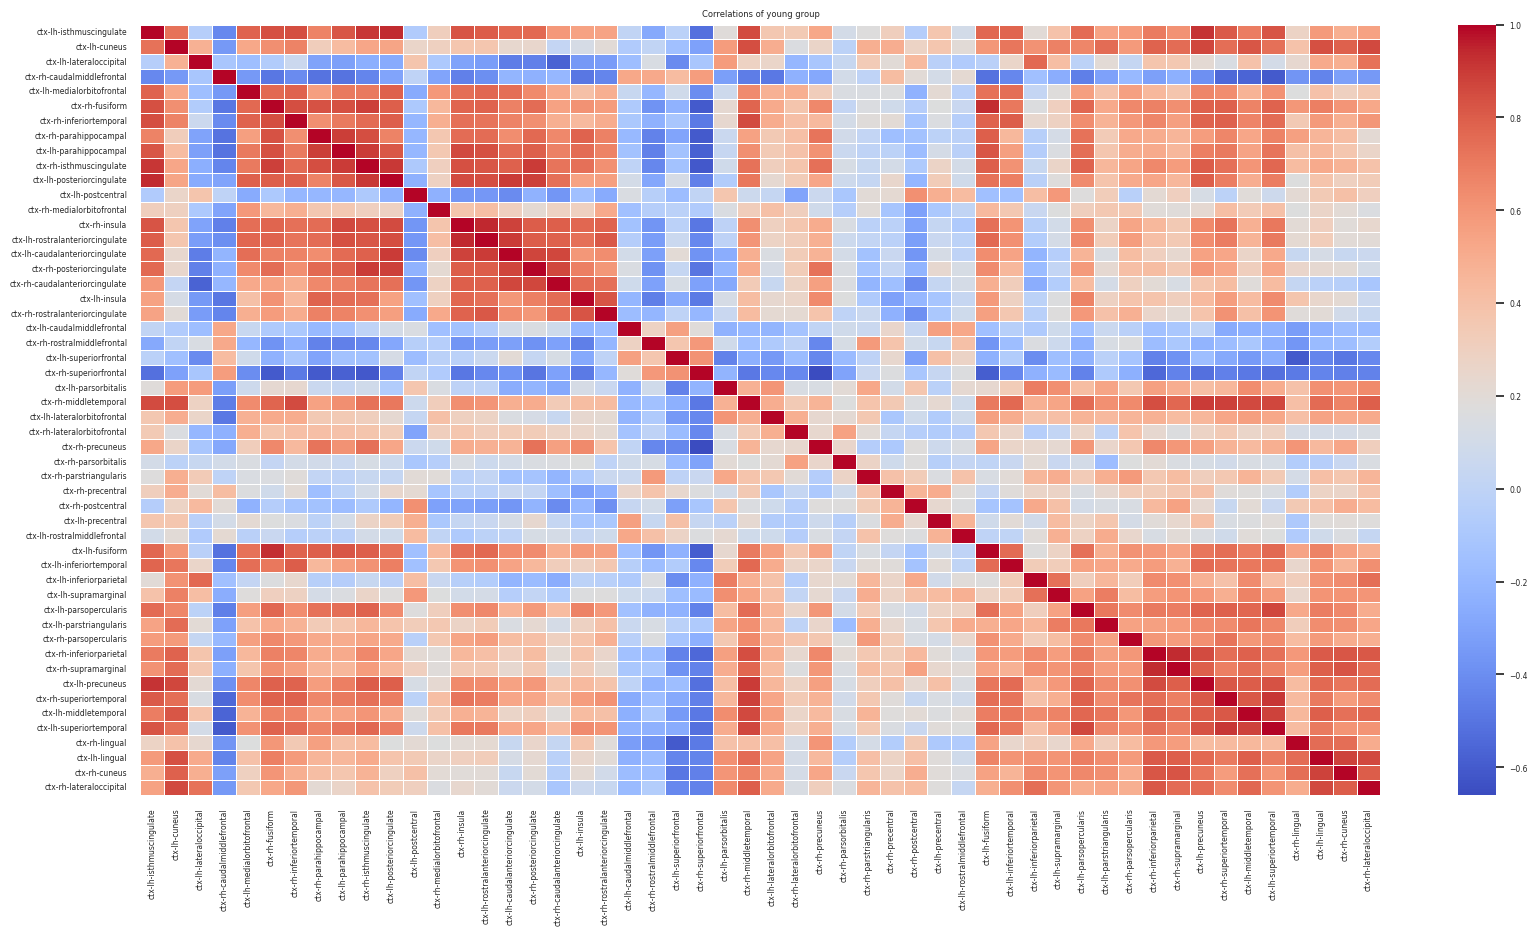

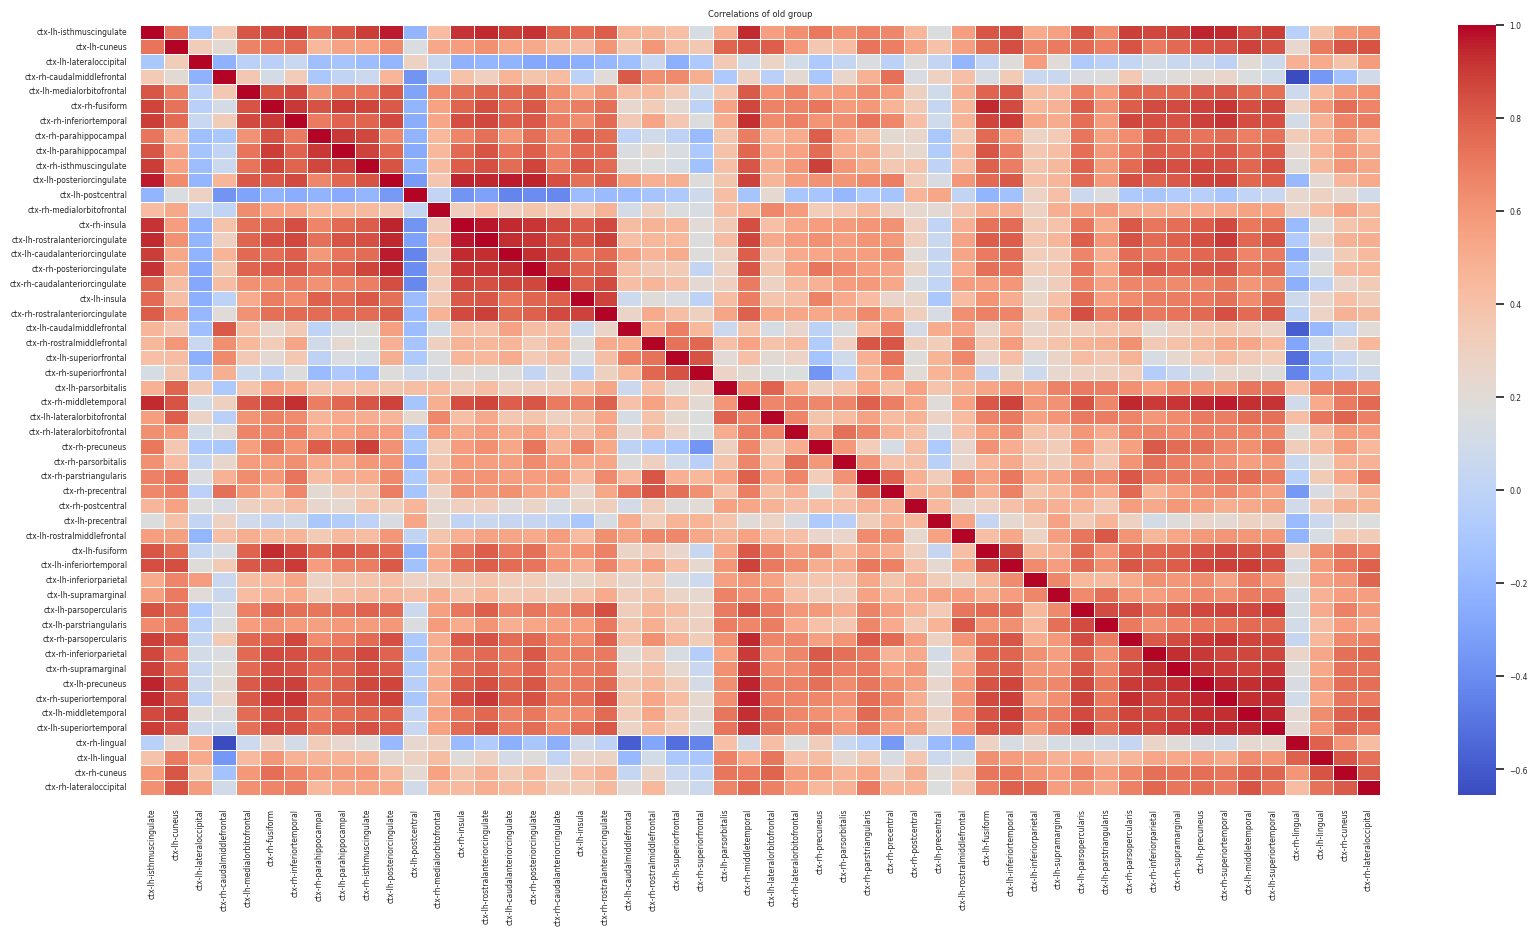

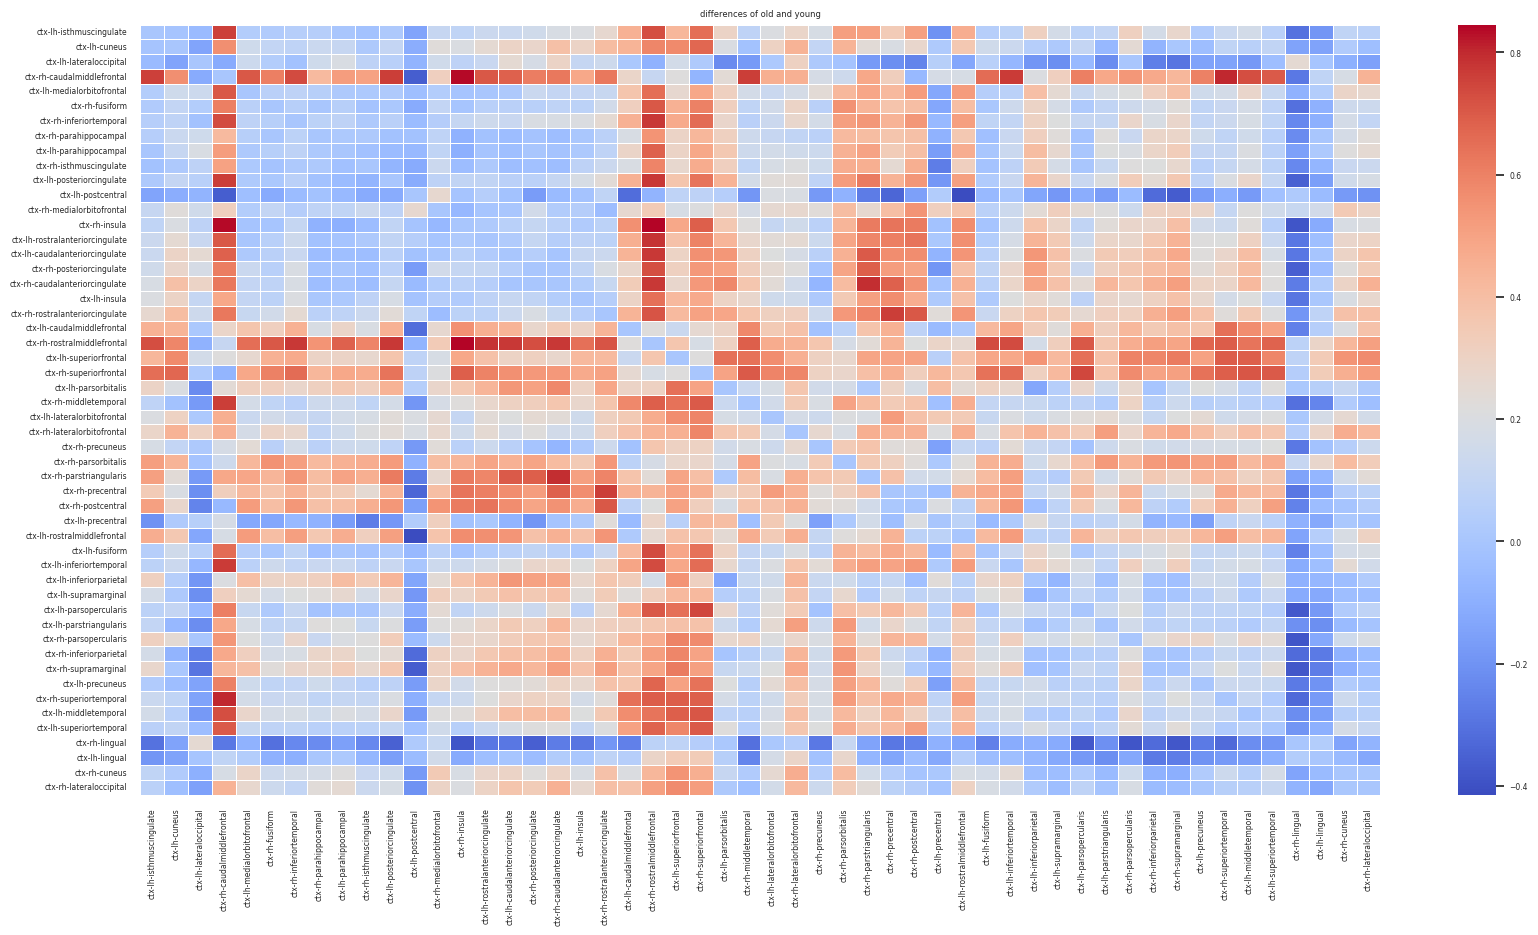

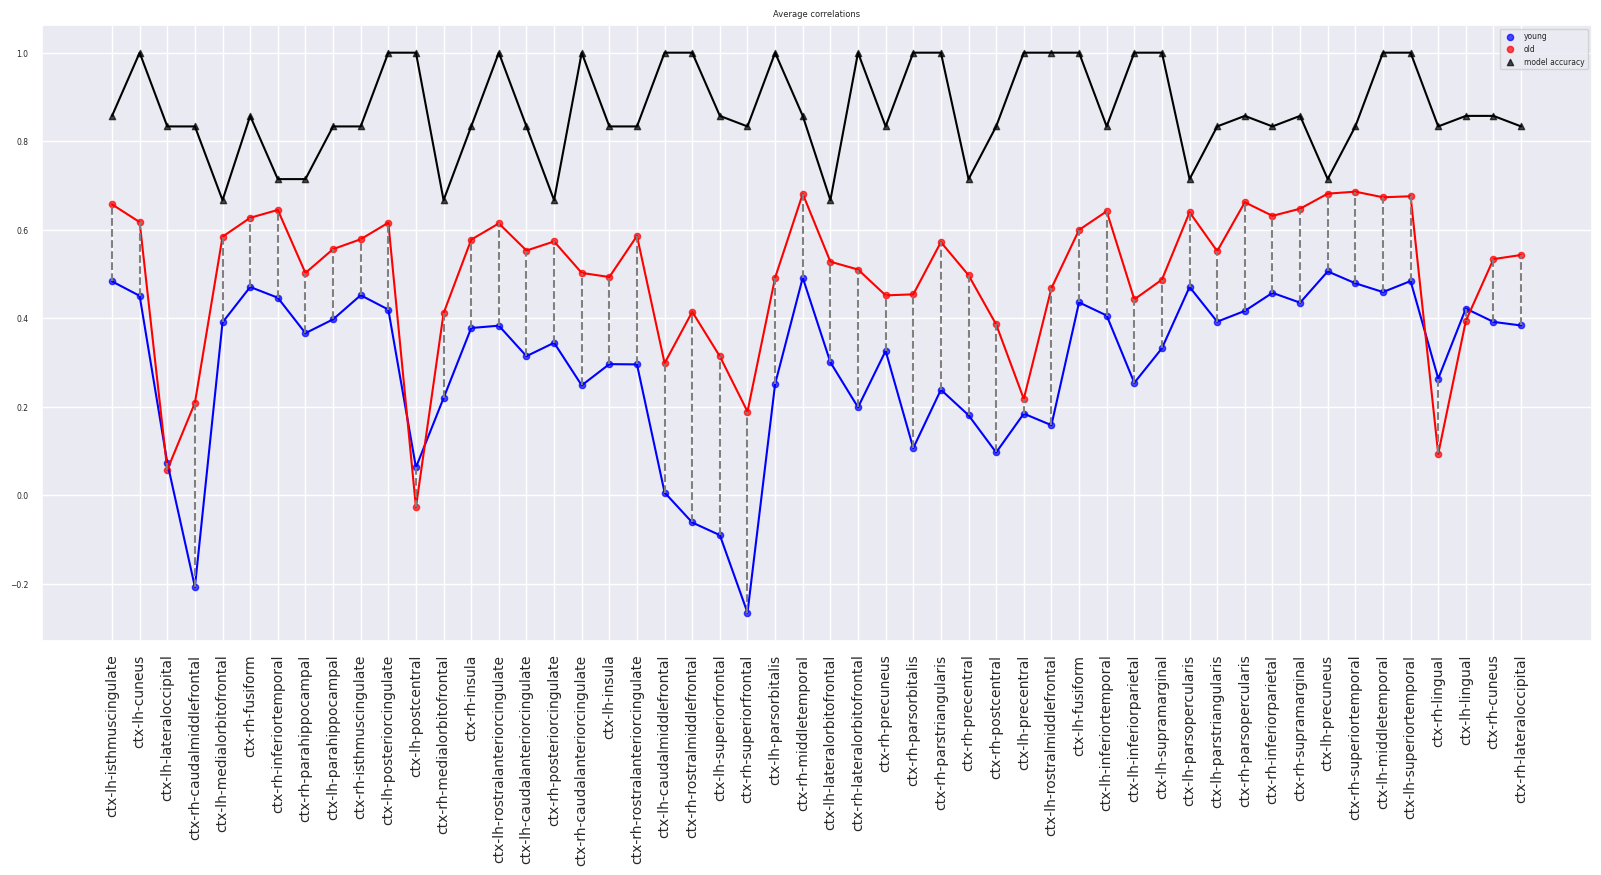

In [94]:
eval_df = create_evaluation_report(x_test, y_test, predictions)
show_correlations_stats(chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'pearson', eval_df)

## Features analysis

In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x[params_to_work_with])

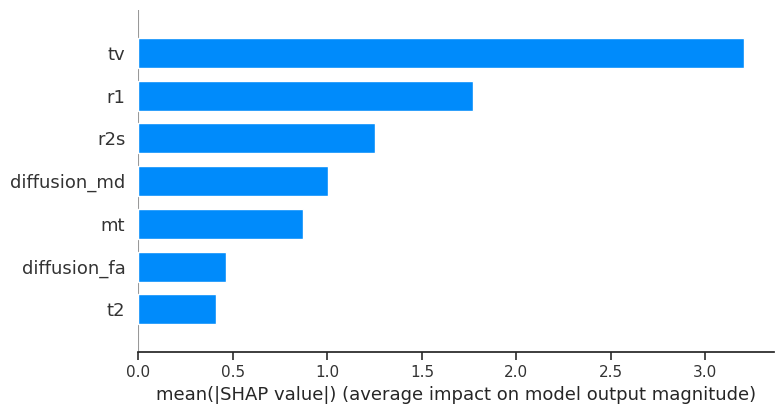

In [32]:
shap.summary_plot(shap_values, x[params_to_work_with], plot_type='bar')

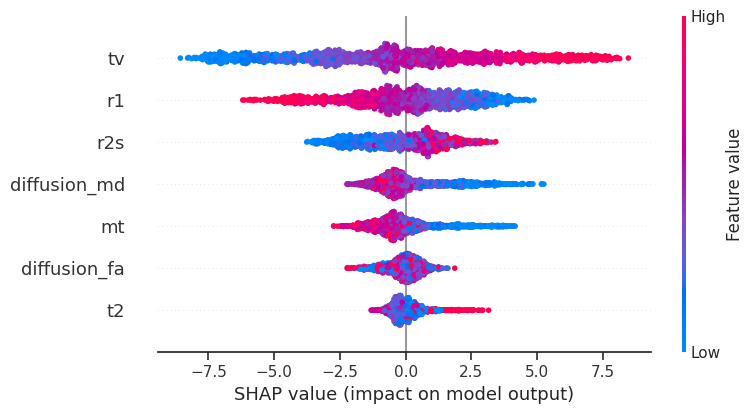

In [33]:
shap.summary_plot(shap_values, x[params_to_work_with])

## Age prediction

In [69]:
random_state = 0
data = chosen_data_raw.copy()
data = data.sample(frac=1, random_state=random_state)
x, y, rois_names = data[params_to_work_with], data['Age'], data['ROI_name']

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)
model = xgb.XGBRegressor(random_state=random_state)

In [36]:
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [37]:
predictions = model.predict(x_test)
print(list(zip(predictions, y_test)))
# Calculating Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)

print("Mean Absolute Error:", mae)

[(74.92319, 57), (70.27571, 57), (23.690292, 24), (40.32855, 24), (21.25737, 26), (66.40177, 70), (25.592772, 27), (29.113468, 25), (26.879782, 25), (34.314133, 31), (43.54944, 65), (69.32406, 68), (71.74691, 75), (46.047928, 27), (61.896786, 57), (30.2313, 67), (62.73916, 73), (31.373978, 23), (72.657036, 75), (18.426542, 26), (24.984415, 26), (61.261116, 75), (33.60317, 31), (51.775093, 68), (30.052082, 25), (43.121857, 63), (63.019787, 61), (37.20808, 26), (29.433975, 31), (64.22685, 69), (55.939762, 65), (71.13925, 71), (35.599335, 63), (42.464252, 57), (62.84059, 63), (24.466295, 24), (25.14884, 29), (38.273727, 26), (38.517906, 23), (54.370472, 27), (73.25424, 70), (60.608524, 70), (64.05845, 69), (75.09227, 71), (31.525484, 23), (65.9857, 57), (36.294796, 27), (45.70679, 68), (65.197845, 67), (76.44429, 57), (24.306843, 25), (70.36146, 70), (55.577423, 67), (23.866545, 23), (26.491203, 25), (33.423183, 31), (47.83546, 24), (26.920101, 24), (63.07106, 24), (65.10892, 69), (66.071

In [38]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x[params_to_work_with])

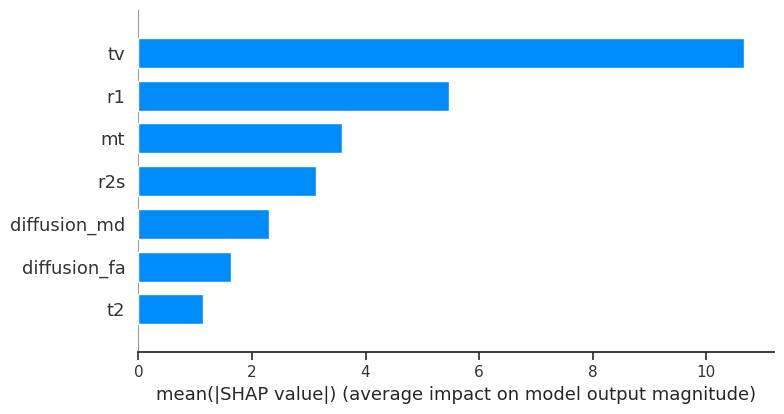

In [39]:
shap.summary_plot(shap_values, x[params_to_work_with], plot_type='bar')